In [ ]:
%load_ext autoreload
%autoreload 2
# !pwd

In [11]:
from pathlib import Path
import pickle
import xarray as xa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

from coralshift import functions_creche
from coralshift.processing import spatial_data
from coralshift.utils import utils
from coralshift.plotting import spatial_plots


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
import sklearn.metrics as sklmetrics

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

from dask.distributed import Client, LocalCluster

import xgboost as xgb

In [3]:
def split_dataset_and_save(ds_fp, divisor, output_dir_name: str=None, select_vars: list[str]=None):
    
    ds = xa.open_dataset(ds_fp)
    
    if select_vars:
        ds = ds[select_vars]
            
    subsets_dict = split_dataset_by_indices(ds, divisor)
    
    # Create a subdirectory to save the split datasets
    if output_dir_name:
        output_dir = Path(ds_fp).parent / f"{output_dir_name}_{divisor**2}_split_datasets"
    else:
        output_dir = Path(ds_fp).parent / f"{divisor**2}_split_datasets"
    output_dir.mkdir(parents=True, exist_ok=True)

    
    for coord_info, subset in tqdm(subsets_dict.items(), desc="saving dataset subsets..."):
        stem_stem = str(Path(ds_fp).stem).split("lats")[0]
        # Construct the filename based on bounds
        filename = f"{stem_stem}_{coord_info}.nc"
        save_fp = output_dir / filename
        subset.to_netcdf(save_fp)
    return subsets_dict
    

def split_dataset_by_indices(dataset, divisor) -> dict:
    subsets_dict = {}
    num_lats = len(dataset.latitude.values) // divisor
    num_lons = len(dataset.longitude.values) // divisor
    for i in range(divisor):
        for j in range(divisor):
            start_lat_ind = i * num_lats
            start_lon_ind = j * num_lons
            
            subset = dataset.isel(latitude=slice(start_lat_ind, start_lat_ind + num_lats),
                                  longitude=slice(start_lon_ind, start_lon_ind + num_lons))
            
            lat_lims = spatial_data.min_max_of_coords(subset, "latitude")
            lon_lims = spatial_data.min_max_of_coords(subset, "longitude")
            
            coord_info = functions_creche.tuples_to_string(lat_lims, lon_lims)
            subsets_dict[coord_info] = subset
    
    return subsets_dict


def ds_to_ml_ready(ds, 
    gt:str="unep_coral_presence", exclude_list: list[str]=["latitude", "longitude", "latitude_grid", "longitude_grid", "crs", "depth", "spatial_ref"], 
    train_val_test_frac=[1,0,0], inf_type: str="classification", threshold=0.5, depth_mask_lims = [-50, 0], client=None, remove_rows:bool=False):
    
    df = ds.compute().to_dataframe()
    # TODO: implement checking for empty dfs

    predictors = [pred for pred in df.columns if pred != gt and pred not in exclude_list]
    depth_condition = (df["elevation"] < max(depth_mask_lims)) & (df["elevation"] > min(depth_mask_lims))
    
    if remove_rows:
        df = df[depth_condition]
    else:
        df["within_depth"] = 0
        df.loc[depth_condition, "within_depth"] = 1
        
    if len(df) > 0:
        scaler = MinMaxScaler()
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = df.index)
    
    df["nan_onehot"] = df.isna().any(axis=1).astype(int)
    df = df.fillna(0)
    
#     X = df[predictors].to_numpy()
#     y = df[gt].to_numpy()
    
    X = df[predictors]
    y = df[gt]
    
    return X, y

def cont_to_class(array, threshold=0.5):
    array[array >= threshold] = 1
    array[array < threshold] = 0

    return array.astype(int)

In [ ]:
# # get hyperparameter dictionaries
# brt_fp = Path("brt_0-0370d_tuned.pickle")

# brt = pickle.load(open(brt_fp,"rb"))
# # brt.best_params_


In [ ]:
param_dict = {'subsample': 0.6,
 'n_estimators': 733,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 7,
 'loss': 'huber',
 'learning_rate': 0.1,
 'criterion': 'friedman_mse',
 'n_iter_no_change': 5}

In [ ]:
# list(X_df.columns)


In [ ]:
# merge_list = [
#     thetao_annual_average.mean(dim="time"),
#     thetao_annual_range,
#     thetao_monthly_min,
#     thetao_monthly_max,
#     thetao_monthly_stdev,
#     thetao_weekly_min,
#     thetao_weekly_max,
#     salinity_annual_average.mean(dim="time"),
#     salinity_monthly_min,
#     salinity_monthly_max,
#     current_annual_average.mean(dim="time"),
#     current_monthly_min,
#     current_monthly_max,
#     solar_annual_average.mean(dim="time"),
#     solar_monthly_min,
#     solar_monthly_max,
#     gt_climate_res,
#     bathymetry_climate_res,
# ]

In [ ]:
num_files = -1
train_nc_fps = list(Path("data/64_split_datasets").glob("temp_rf*.nc"))[:num_files]

train_Xs, train_ys = [], []
for i, fp in tqdm(enumerate(train_nc_fps), total=len(train_nc_fps)):
    ds = xa.open_dataset(fp)
    X, y = ds_to_ml_ready(ds, remove_rows=True)
#     print(sum(y))
    train_Xs.append(X)
    train_ys.append(y)


In [ ]:
lim_predictors = True

if lim_predictors:
    predictors = [s for s in train_Xs[0].columns if s.startswith("thetao") and not (s.endswith("min") or s.endswith("max"))] + [
        "so_overall_mean", "so_september_min", "so_may_max"] + ["vo_overall_mean", "so_september_min", "so_may_max"] + ["uo_overall_mean", "so_september_min", "so_may_max"] + ["elevation", "seafloor_slope"]
    X_df = pd.concat(train_Xs, axis=0)[predictors]
else:
    X_df = pd.concat(train_Xs, axis=0)
y_df = pd.concat(train_ys, axis=0)

In [ ]:
X_df.columns

In [ ]:
X = X_df.to_numpy()
y = y_df.to_numpy()

print("X shape:", X.shape)
print("y shape:", y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_samples = 10000

# GradientBoostingRegressor from previous best parameters

In [ ]:
# Initializing and training the Gradient Boosting Regression model
boosted_model = GradientBoostingRegressor(**param_dict, verbose=1)
boosted_model.fit(X_train[:n_samples], y_train[:n_samples])

# Evaluating the model
train_score = boosted_model.score(X_train[:n_samples], y_train[:n_samples])
test_score = boosted_model.score(X_test[:n_samples], y_test[:n_samples])

print(f"Training R^2 score: {train_score:.3f}")
print(f"Test R^2 score: {test_score:.3f}")

In [ ]:
y_train[:100]

# GradientBoostingRegressor RandomizedSearchCV

In [ ]:
# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

param_space = {
    'alpha': [0.1, 0.5, 0.99],  # Example values, adjust ranges as needed
    'ccp_alpha': [0.0, 0.1, 0.2],
    'criterion': ['squared_error', 'friedman_mse'],
    'learning_rate': [0.01, 0.1, 0.3],
    'loss': ['absolute_error'],
    'max_depth': [3, 5, 7, 10],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'n_iter_no_change': [None, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'tol': [0.001, 0.01],
    'warm_start': [False, True]
}

model = GradientBoostingRegressor()
search = RandomizedSearchCV(model, param_space, cv=3, n_iter=50, verbose=1)

with joblib.parallel_backend('dask'):
    search.fit(X_train[:n_samples], y_train[:n_samples])

In [ ]:
# prev_best_params = {'warm_start': False,
#  'validation_fraction': 0.2,
#  'tol': 0.001,
#  'subsample': 0.7,
#  'n_iter_no_change': 10,
#  'n_estimators': 200,
#  'min_weight_fraction_leaf': 0.0,
#  'min_samples_split': 2,
#  'min_samples_leaf': 4,
#  'min_impurity_decrease': 0.1,
#  'max_leaf_nodes': 20,
#  'max_features': 'sqrt',
#  'max_depth': 5,
#  'loss': 'absolute_error',
#  'learning_rate': 0.1,
#  'criterion': 'friedman_mse',
#  'ccp_alpha': 0.0,
#  'alpha': 0.5}
search.best_params_

In [ ]:
model = GradientBoostingRegressor(**search.best_params_)
model.fit(X_train,y_train)

In [ ]:
plt.scatter(y_test, model.predict(X_test), alpha=0.1)

# sklmetrics.accuracy_score(y_test, search.predict(X_test)) # only for regression

# RandomForestClassifier

In [ ]:
# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

class_counts = np.bincount(y_train)
total_samples = len(y_train)

class_weight = {
    0: total_samples / (2 * class_counts[0]),
    1: total_samples / (2 * class_counts[1])
}

param_space = {
    'bootstrap': [True, False],
    'ccp_alpha': [0.0, 0.1, 0.2],
    'class_weight': ['balanced', class_weight],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20],
#     'max_samples': [None, 0.5, 0.7, 0.9],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'oob_score': [True, False],
    'random_state': [42],  # Add different seed values if desired
#     'warm_start': [True, False]
    # Add more parameters and ranges as needed
}


y_train = cont_to_class(y_train, 0.25)

model = RandomForestClassifier()
search = RandomizedSearchCV(model, param_space, cv=3, n_iter=50, verbose=0, n_jobs=-1)

with joblib.parallel_backend('dask'):
    search.fit(X_train[:n_samples], y_train[:n_samples])

In [ ]:
print(search.best_params_)
model = RandomForestClassifier(**search.best_params_)
model.fit(X_train,y_train)

In [ ]:
plt.scatter(y_train, model.predict(X_train), alpha=0.1)
plt.xlabel("labels")
plt.ylabel("prediction")

# sklmetrics.accuracy_score(y_test, search.predict(X_test)) # only for regression

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(cont_to_class(y_test, 0.4), cont_to_class(model.predict(X_test), 0.5), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"])

disp.plot()

In [ ]:
sklmetrics.f1_score(cont_to_class(y_test, 0.25), cont_to_class(model.predict(X_test), 0.5))

In [ ]:
# import matplotlib.pyplot as plt

# from sklearn import svm
# from sklearn.metrics import RocCurveDisplay, auc
# from sklearn.model_selection import StratifiedKFold

# n_splits = 6
# cv = StratifiedKFold(n_splits=n_splits)
# classifiier = 

# tprs = []
# aucs = []
# mean_fpr = np.linspace(0, 1, 100)

# fig, ax = plt.subplots(figsize=(6, 6))
# for fold, (train, test) in enumerate(cv.split(X, y)):
#     classifier.fit(X[train], y[train])
#     viz = RocCurveDisplay.from_estimator(
#         classifier,
#         X[test],
#         y[test],
#         name=f"ROC fold {fold}",
#         alpha=0.3,
#         lw=1,
#         ax=ax,
#         plot_chance_level=(fold == n_splits - 1),
#     )
#     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
#     interp_tpr[0] = 0.0
#     tprs.append(interp_tpr)
#     aucs.append(viz.roc_auc)

# mean_tpr = np.mean(tprs, axis=0)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
# ax.plot(
#     mean_fpr,
#     mean_tpr,
#     color="b",
#     label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
#     lw=2,
#     alpha=0.8,
# )

# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# ax.fill_between(
#     mean_fpr,
#     tprs_lower,
#     tprs_upper,
#     color="grey",
#     alpha=0.2,
#     label=r"$\pm$ 1 std. dev.",
# )

# ax.set(
#     xlim=[-0.05, 1.05],
#     ylim=[-0.05, 1.05],
#     xlabel="False Positive Rate",
#     ylabel="True Positive Rate",
#     title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
# )
# ax.axis("square")
# ax.legend(loc="lower right")
# plt.show()


# Recreating MRes

In [4]:
couce = xa.open_dataset("data/GBR_A_Couce_comparison.nc")
couce

<xarray.Dataset>
Dimensions:              (latitude: 190, longitude: 136)
Coordinates:
  * longitude            (longitude) float64 142.0 142.0 142.1 ... 147.0 147.0
  * latitude             (latitude) float64 -17.0 -16.96 -16.93 ... -10.04 -10.0
    spatial_ref          int64 ...
    band                 int64 ...
Data variables: (12/18)
    thetao_y_mean        (latitude, longitude) float64 ...
    thetao_annual_range  (latitude, longitude) float64 ...
    thetao_m_min         (latitude, longitude) float64 ...
    thetao_m_max         (latitude, longitude) float64 ...
    thetao_m_std         (latitude, longitude) float64 ...
    thetao_w_min         (latitude, longitude) float64 ...
    ...                   ...
    current_m_max        (latitude, longitude) float64 ...
    net_solar_y_mean     (latitude, longitude) float64 ...
    net_solar_m_min      (latitude, longitude) float64 ...
    net_solar_m_max      (latitude, longitude) float64 ...
    gt                   (latitude, longitude) float64 ...
    bathymetry           (latitude, longitude) float64 ...
Attributes:
    region:   A

In [5]:
X = couce.to_dataframe()
X

thetao_y_mean  thetao_annual_range  thetao_m_min   
latitude longitude                                                      
-17.0    142.000000            NaN                  NaN           NaN  \
         142.037037            NaN                  NaN           NaN   
         142.074074            NaN                  NaN           NaN   
         142.111111            NaN                  NaN           NaN   
         142.148148            NaN                  NaN           NaN   
...                            ...                  ...           ...   
-10.0    146.851852      27.644547             7.423405     23.891201   
         146.888889      27.633005             7.451401     23.893154   
         146.925926      27.620630             7.469385     23.902431   
         146.962963      27.605756             7.457340     23.933683   
         147.000000      27.590882             7.445293     23.964935   

                     thetao_m_max  thetao_m_std  thetao_w_min  thetao_w_max   
latitude longitude                                                            
-17.0    142.000000           NaN           NaN           NaN           NaN  \
         142.037037           NaN           NaN           NaN           NaN   
         142.074074           NaN           NaN           NaN           NaN   
         142.111111           NaN           NaN           NaN           NaN   
         142.148148           NaN           NaN           NaN           NaN   
...                           ...           ...           ...           ...   
-10.0    146.851852     31.314606      1.586572     23.891201     31.314606   
         146.888889     31.344555      1.597705     23.893154     31.344555   
         146.925926     31.371817      1.608783     23.902431     31.371817   
         146.962963     31.391024      1.619148     23.933683     31.391024   
         147.000000     31.410229      1.629798     23.964935     31.410229   

                     salinity_y_mean  salinity_m_min  salinity_m_max   
latitude longitude                                                     
-17.0    142.000000              NaN             NaN             NaN  \
         142.037037              NaN             NaN             NaN   
         142.074074              NaN             NaN             NaN   
         142.111111              NaN             NaN             NaN   
         142.148148              NaN             NaN             NaN   
...                              ...             ...             ...   
-10.0    146.851852        34.599931       30.363543       35.608997   
         146.888889        34.601904       30.407625       35.608997   
         146.925926        34.603632       30.470018       35.608490   
         146.962963        34.604625       30.587345       35.606453   
         147.000000        34.605618       30.642109       35.604420   

                     current_y_mean  current_m_min  current_m_max   
latitude longitude                                                  
-17.0    142.000000             NaN            NaN            NaN  \
         142.037037             NaN            NaN            NaN   
         142.074074             NaN            NaN            NaN   
         142.111111             NaN            NaN            NaN   
         142.148148             NaN            NaN            NaN   
...                             ...            ...            ...   
-10.0    146.851852        0.308523       0.004780       1.087711   
         146.888889        0.305795       0.005536       1.119539   
         146.925926        0.302395       0.005172       1.131140   
         146.962963        0.296977       0.007622       1.082063   
         147.000000        0.291559       0.002441       1.095413   

                     net_solar_y_mean  net_solar_m_min  net_solar_m_max   gt   
latitude longitude                                                             
-17.0    142.000000     733683.149199     49926.

In [6]:
def xa_dss_to_df(
    xa_dss: list[xa.Dataset],
    bath_mask: bool = True,
    ignore_vars: list = ["spatial_ref", "band", "depth"],
    drop_all_nans: bool = True,
):
    dfs = []
    for xa_ds in xa_dss:
        if bath_mask:
            # set all values outside of the shallow water region to nan for future omission
            shallow_mask = spatial_data.generate_var_mask(xa_ds,mask_var="bathymetry"
#                                                           ,limits=[-2000,0]
                                                         )
            xa_ds = xa_ds.where(shallow_mask, np.nan)

        # compute out dasked chunks, send type to float32, stack into df, drop any datetime columns
        df = (
            xa_ds.stack(points=("latitude", "longitude"))
            .compute()
            .astype("float32")
            .to_dataframe()
        )
        # drop temporal columns
        df = df.drop(columns=list(df.select_dtypes(include="datetime64").columns))
        df = process_df_for_ml(df, ignore_vars=ignore_vars, drop_all_nans=drop_all_nans)

        dfs.append(df)
    return dfs


def process_df_for_ml(
    df: pd.DataFrame, ignore_vars: list[str], drop_all_nans: bool = True
) -> pd.DataFrame:
    # drop ignored vars
    df = df.drop(columns=list(set(ignore_vars).intersection(df.columns)))

    if drop_all_nans:
        # remove rows which are all nans
        df = utils.drop_nan_rows(df)
    # onehot encoode any remaining nans
    df["onehotnan"] = df.isnull().any(axis=1).astype(int)
    # fill nans with 0
    df = df.fillna(0)

    # flatten dataset for row indexing and model training
    return df


def generate_split(ds):
    
    # flatten datasets to pandas dataframes and process
    flattened_data_dfs = xa_dss_to_df([couce], bath_mask=True)
    # generate training and testing coordinates

    # normalise dataframe via min/max scaling
    normalised_dfs = [
        (flattened_data - flattened_data.min())
        / (flattened_data.max() - flattened_data.min())
        for flattened_data in flattened_data_dfs
    ]

    couce_y = normalised_dfs[0]["gt"].to_numpy()
    couce_X = normalised_dfs[0].loc[:, normalised_dfs[0].columns != 'gt'].to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(couce_X, couce_y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

def get_min_max_coords(ds, coord):
    min_coord = float(min(ds[coord]).values)
    max_coord = float(max(ds[coord]).values)
    return min_coord, max_coord

In [ ]:
len(couce.latitude)/7

In [8]:
resolutions = [1, 0.5, 1/12, 1/27]

def train_classifier(X_train, y_train, cv=3, n_iter=50, n_samples=-1):
    cluster = LocalCluster(n_workers=4)
    client = Client(cluster)

    y_train = cont_to_class(y_train, 0.25)

    class_counts = np.bincount(y_train)
    total_samples = len(y_train)

    class_weight = {
        0: total_samples / (2 * class_counts[0]),
        1: 5*total_samples / (2 * class_counts[1])
    }

    param_space = {
        'bootstrap': [True, False],
        'ccp_alpha': [0.0, 0.1, 0.2],
        'class_weight': ['balanced', class_weight],
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 7, 10, 50, 100],
        'max_features': ['sqrt', 'log2'],
        'max_leaf_nodes': [None, 5, 10, 20],
    #     'max_samples': [None, 0.5, 0.7, 0.9],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'oob_score': [True, False],
        'random_state': [42],  # Add different seed values if desired
    #     'warm_start': [True, False]
        # Add more parameters and ranges as needed
    }

    model = RandomForestClassifier()
    search = RandomizedSearchCV(model, param_space, cv=cv, n_iter=n_iter, verbose=1, n_jobs=-1)

    with joblib.parallel_backend('dask'):
        search.fit(X_train[:n_samples], y_train[:n_samples])
    client.close()
    
    return search.best_params_



def models_at_resolutions(high_res_ds, resolutions:list, model_type, cv, n_iter, n_samples):
    
    models = []
    best_param_dicts = {}
    accuracy_scores = []
    f1_scores = []
    
    for res in tqdm(resolutions):
        lat_range = get_min_max_coords(high_res_ds, "latitude")
        lon_range = get_min_max_coords(high_res_ds, "longitude")
        
        ds_res = functions_creche.resample_xa_d(high_res_ds, lat_range, lon_range, res, res)
        
        X_train, X_test, y_train, y_test = generate_split(ds_res)
        
        
        if model_type == "classifier":
            best_params = train_classifier(X_train, y_train, cv, n_iter, n_samples)
            best_param_dicts[res] = best_params
            
            model = RandomForestClassifier(**best_params)
            model.fit(X_train, y_train)
            models.append(model)
            
            accuracy_score = sklmetrics.accuracy_score(cont_to_class(y_test, 0.25), cont_to_class(model.predict(X_test), 0.5))
            f1_score = sklmetrics.f1_score(cont_to_class(y_test, 0.25), cont_to_class(model.predict(X_test), 0.5))
            
            with open(f"rf_cl_standard_-2000-0_{res:.03f}.pickle", "wb") as handle:
                pickle.dump(best_params, handle, protocol=-1)
    
    
            accuracy_scores.append(accuracy_score)
            f1_scores.append(f1_score)
            print(f"resolution: {res}°")
            print(f"accuracy_score: {accuracy_score}")
            print(f"f1_score: {f1_score}")           
        
    return best_param_dicts, models, accuracy_score, f1_score

best_param_dicts, models = models_at_resolutions(couce, resolutions, model_type="classifier", cv=7, n_iter=70, n_samples=-1)

  0%|          | 0/4 [00:00<?, ?it/s]/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38217 instead
  warnings.warn(


Fitting 7 folds for each of 70 candidates, totalling 490 fits


2023-11-22 02:00:23,968 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:00:26,997 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-11-22 02:00:27,386 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:00:28,997 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-11-22 02:00:30,645 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:00:30,803 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:00:32,855 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-11-22 02:00:32,917 - distributed.utils_perf - WARNING - full garbage collections took

resolution: 1°
accuracy_score: 0.6622448979591836
f1_score: 0.4141592920353982


/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39265 instead
  warnings.warn(


Fitting 7 folds for each of 70 candidates, totalling 490 fits


2023-11-22 02:02:42,460 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:02:44,894 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:02:47,780 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:02:50,567 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:02:53,798 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:02:57,426 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:03:01,258 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:03:06,022 - distributed.utils_perf - WARNING - full garbage collections took

resolution: 0.5°
accuracy_score: 0.6622448979591836
f1_score: 0.4141592920353982


/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35315 instead
  warnings.warn(


Fitting 7 folds for each of 70 candidates, totalling 490 fits


2023-11-22 02:04:58,691 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-11-22 02:05:03,279 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-11-22 02:05:06,863 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-11-22 02:05:10,555 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-11-22 02:05:13,832 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:05:16,635 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:05:19,869 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-22 02:05:24,036 - distributed.utils_perf - WARNING - full garbage collections took

resolution: 0.08333333333333333°
accuracy_score: 0.6622448979591836
f1_score: 0.4141592920353982


/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32835 instead
  warnings.warn(


Fitting 7 folds for each of 70 candidates, totalling 490 fits


/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
133 fits failed out of a total of 490.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
133 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag

resolution: 0.037037037037037035°
accuracy_score: 0.8484693877551021
f1_score: 0.6127770534550195


(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'thetao_y_mean at 0.0370° (~4018 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f3808b94970>)

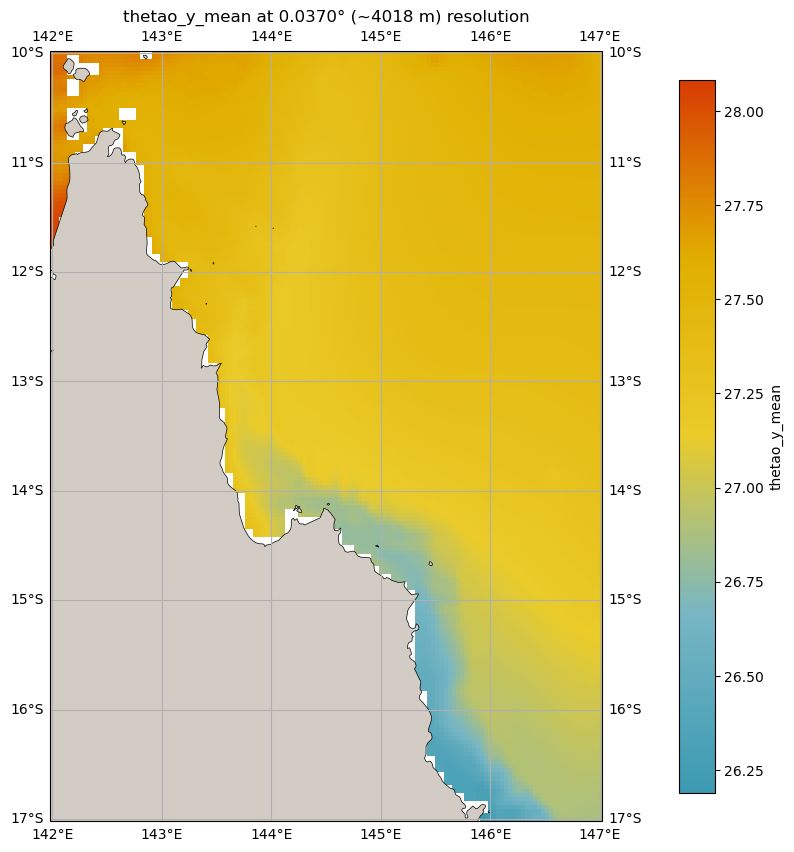

In [15]:
lat_range = get_min_max_coords(couce, "latitude")
lon_range = get_min_max_coords(couce, "longitude")
resolutions = [1, 0.5, 1/12, 1/27]


i=3
res = resolutions[i]
spatial_plots.plot_spatial(
    functions_creche.resample_xa_d(couce, lat_range, lon_range, res, res)["thetao_y_mean"])

In [ ]:
best_param_dicts.values()

In [ ]:
from coralshift.processing import spatial_data
from coralshift.utils import utils



# flatten datasets to pandas dataframes and process
flattened_data_dfs = xa_dss_to_df([couce], bath_mask=True)
# generate training and testing coordinates

# normalise dataframe via min/max scaling
normalised_dfs = [
    (flattened_data - flattened_data.min())
    / (flattened_data.max() - flattened_data.min())
    for flattened_data in flattened_data_dfs
]
normalised_dfs[0]

In [ ]:
normalised_dfs[0]["gt"].to_numpy()

In [ ]:
couce_y = normalised_dfs[0]["gt"].to_numpy()
couce_X = normalised_dfs[0].loc[:, normalised_dfs[0].columns != 'gt'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(couce_X, couce_y, test_size=0.2, random_state=42)


In [ ]:
# # get hyperparameter dictionaries
# brt_fp = Path("brt_0-0370d_tuned.pickle")

# brt = pickle.load(open(brt_fp,"rb"))
# # brt.best_params_


# rf_classifier = 
sum(y_train)


In [ ]:
# client.close()
# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

n_samples = -1

y_train = cont_to_class(y_train, 0.25)

class_counts = np.bincount(y_train)
total_samples = len(y_train)

class_weight = {
    0: total_samples / (2 * class_counts[0]),
    1: 5*total_samples / (2 * class_counts[1])
}

param_space = {
    'bootstrap': [True, False],
    'ccp_alpha': [0.0, 0.1, 0.2],
    'class_weight': ['balanced', class_weight],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20],
#     'max_samples': [None, 0.5, 0.7, 0.9],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'oob_score': [True, False],
    'random_state': [42],  # Add different seed values if desired
#     'warm_start': [True, False]
    # Add more parameters and ranges as needed
}

model = RandomForestClassifier()
search = RandomizedSearchCV(model, param_space, cv=3, n_iter=50, verbose=1, n_jobs=-1)

with joblib.parallel_backend('dask'):
    search.fit(X_train[:n_samples], y_train[:n_samples])

In [ ]:
# save best params to pickle
with open("rf_cl_standard_-2000-0.pickle", "wb") as handle:
    pickle.dump(search.best_params_, handle, protocol=-1)


In [ ]:
print(search.best_params_)
model = RandomForestClassifier(**search.best_params_)
model.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(cont_to_class(y_test, 0.25), cont_to_class(model.predict(X_test), 0.5), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"])

disp.plot()

In [ ]:
sklmetrics.accuracy_score(cont_to_class(y_test, 0.25), cont_to_class(model.predict(X_test), 0.5))

In [ ]:
couce_y = normalised_dfs[0]["gt"].to_numpy()
couce_X = normalised_dfs[0].loc[:, normalised_dfs[0].columns != 'gt'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(couce_X, couce_y, test_size=0.2, random_state=42)

In [ ]:
# local dask cluster
client.close()
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

param_space = {
    'alpha': [0.1, 0.5, 0.99],  # Example values, adjust ranges as needed
    'ccp_alpha': [0.0, 0.1, 0.2],
    'criterion': ['squared_error', 'friedman_mse'],
    'learning_rate': [0.01, 0.1, 0.3],
    'loss': ['absolute_error'],
    'max_depth': [3, 5, 7, 10],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'n_iter_no_change': [None, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'tol': [0.001, 0.01],
    'warm_start': [False, True]
}

model = GradientBoostingRegressor()
search = RandomizedSearchCV(model, param_space, cv=3, n_iter=50, verbose=1)

with joblib.parallel_backend('dask'):
    search.fit(X_train[:n_samples], y_train[:n_samples])

In [ ]:
# save best params to pickle
with open("rf_gbr_standard_-2000-0.pickle", "wb") as handle:
    pickle.dump(search.best_params_, handle, protocol=-1)

In [ ]:
model = GradientBoostingRegressor(**search.best_params_)
model.fit(X_train,y_train)

plt.scatter(y_test, model.predict(X_test), alpha=0.1)

In [ ]:
# # this is really just too slow to be feasible

# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
# #         'seed': 0,
#        "subsample": hp.uniform('subsample', 0, 1),
#        "eta": hp.quniform("eta", 0, 1, 0.1),
#        "scale_pos_weight": hp.quniform("scale_pos_weight", 5, 99, 5)
#     }

# n_samples = 1000

# def objective(space):
#     threshold = 0.5
#     clf=xgb.XGBClassifier(
#                     max_depth = int(space['max_depth']), 
#                     gamma = space['gamma'],
#                     reg_alpha = int(space['reg_alpha']),
#                     reg_lambda = space["reg_lambda"],
#                     colsample_bytree=int(space['colsample_bytree']),
#                     min_child_weight=int(space['min_child_weight']),
#                     n_estimators = space['n_estimators'], 
#                     subsample = space["subsample"],
#                     eta = space["eta"],
#                     scale_pos_weight = space["scale_pos_weight"],
#                     eval_metric="auc",
#                     early_stopping_rounds=10)
    
#     evaluation = [(X_train[:n_samples], cont_to_class(y_train[:n_samples],threshold)), ( X_test[:n_samples], cont_to_class(y_test[:n_samples],threshold))]
    
    
    
#     clf.fit(X_train[:n_samples], y_train[:n_samples],
#             eval_set=evaluation,verbose=False)
    

#     pred = clf.predict(X_test[:n_samples])
#     accuracy = accuracy_score(cont_to_class(y_test[:n_samples], threshold), pred>0.5)
#     print(f"SCORE: {accuracy}")
#     return {'loss': -accuracy, 'status': STATUS_OK }

# trials = Trials()
# # takes a while to run
# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)